In [1]:
import ipywidgets as widgets

## Kmeans

(427, 640, 3)

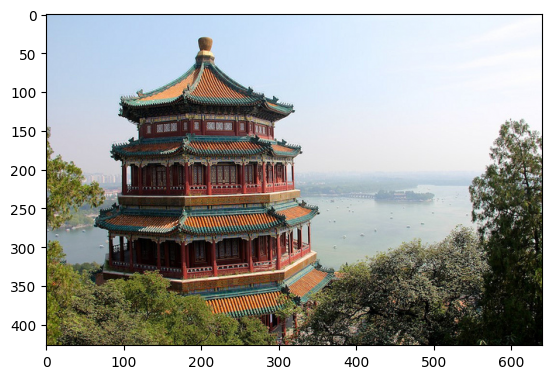

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 5

# Load the Summer Palace photo
origin = load_sample_image('china.jpg')
origin = np.array(origin, dtype=np.float64) / 255
w, h, d = original_shape = tuple(origin.shape)
image_array = np.reshape(origin, (w * h, d))

fi, axes = plt.subplots(1, 1)
axes.imshow(origin)
origin.shape

In [ ]:
widgets.ColorPicker(
    concise=False,
    description='Pixel Color',
    value='blue',
    disabled=False
)

In [ ]:
kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=0)
kmeans.fit(image_array)

fi, axes = plt.subplots(1, 1)
axes.imshow([kmeans.cluster_centers_])
axes.axis('off')

In [ ]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

predicted = recreate_image(kmeans.cluster_centers_, labels, w, h)

# Display all results, alongside original image
fi, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].imshow(origin)
axes[0].axis('off')
axes[1].imshow([kmeans.cluster_centers_] )
axes[1].axis('off')
axes[2].imshow(predicted)
axes[2].axis('off')

# EEG

In [ ]:
from mne.io import read_raw_eeglab

from pycrostates.cluster import ModKMeans
from pycrostates.datasets import lemon

# load sample dataset
raw_fname = lemon.data_path(subject_id='010017', condition='EC')
raw = read_raw_eeglab(raw_fname, preload=True)
raw.crop(0, 10)  # crop the dataset to speed up computation
raw.pick('eeg')  # select EEG channels
raw.set_eeg_reference('average')  # Apply a common average reference
raw.plot()

In [ ]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib notebook
import mne
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
 
data = raw.get_data()
@widgets.interact(t=(0, raw.n_times))
def update(t):
    """Remove old lines from plot and plot new one"""
    ax.clear()
    mne.viz.plot_topomap(data[:,t], raw.info, axes=ax)

In [ ]:
n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters, random_state=42)

After creating a :class:`~pycrostates.cluster.ModKMeans`, the next step is to
fit the model. In other words, fitting a clustering algorithm will determine
the microstate maps, also called :term:`cluster centers`. A clustering
algorithm can be fitted with :class:`~mne.io.Raw`,
:class:`~mne.epochs.Epochs` or :class:`~pycrostates.io.ChData` objects.

<div class="alert alert-info"><h4>Note</h4><p>Fitting a clustering algorithm is a computationaly expensive operation.
    Depending on your configuration, you can change the argument ``n_jobs``
    to take advantage of multiprocessing to reduce computation time.</p></div>



In [ ]:
ModK.fit(raw, n_jobs=5)

Now that our algorithm is fitted, we can visualize the
:term:`cluster centers`, also called microstate maps or microstate
topographies using :meth:`pycrostates.cluster.ModKMeans.plot`.



In [ ]:
ModK.plot();

The :term:`cluster centers` can be retrieved as a numpy array with the
``cluster_centers_`` attribute.



By default, the :term:`cluster centers` are named from ``0`` to
``n_clusters - 1`` and are ordered based on the fit. You can reorder
(:meth:`pycrostates.cluster.ModKMeans.reorder_clusters`) and
rename (:meth:`pycrostates.cluster.ModKMeans.rename_clusters`) each
microstates to match your preference.



In [ ]:
ModK.reorder_clusters(order=[3, 0, 1, 2, 4])
ModK.rename_clusters(new_names=['A', 'B', 'C', 'D', 'F'])
ModK.plot();

### Predict

In [ ]:
segmentation = ModK.predict(
    raw,
    reject_by_annotation=True,
    factor=10,
    half_window_size=10,
    min_segment_length=5,
    reject_edges=False,
)

In [ ]:
segmentation._labels

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
segmentation.plot(axes=axes);
axes.set_ylim(0, 1e-6)
axes.get_yaxis().set_ticks([])

### Reject by annotations

In [ ]:
raw_ = raw.copy()
annotation = mne.Annotations(2, 2, 'bad')
raw_.set_annotations(annotation)
seg = ModK.predict(
    raw_,
    reject_by_annotation=True,
    factor=10,
    half_window_size=10,
    min_segment_length=5,
    reject_edges=False,
)

fig, axes = plt.subplots(2, 1, figsize=(10,5))
seg.plot(axes=axes[0]);
axes[0].set_ylim(0, 1e-6)
axes[0].get_yaxis().set_ticks([])

segmentation.plot(axes=axes[1]);
axes[1].set_ylim(0, 1e-6)
axes[1].get_yaxis().set_ticks([])

### Smoothing

The map polarities can be inverted using the
:meth:`pycrostates.cluster.ModKMeans.invert_polarity`.
method. Note that it only affects visualization, it has not effect during
backfitting as polarities are ignored.



In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img =  predicted
kernel = np.ones((10,10),np.float32)/10**2
dst = cv.filter2D(img,-1,kernel)

# Display all results, alongside original image
fi, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].imshow(origin)
axes[0].axis('off')
axes[1].imshow(predicted)
axes[1].axis('off')
axes[2].imshow(dst)
axes[2].axis('off')

#### half_window_sizes

In [ ]:
half_window_sizes = [0, 5, 10, 20]

fig, axes = plt.subplots(len(half_window_sizes), 1, figsize=(12,8))
for h, half_window_size in enumerate(half_window_sizes):
    ax = axes[h]
    segmentation = ModK.predict(
        raw,
        reject_by_annotation=True,
        factor=10,
        half_window_size=half_window_size)
    segmentation.plot(axes=ax)
    ax.set_ylim(0, 1e-6)
    ax.get_yaxis().set_ticks([])

### min_segment_length

In [ ]:
min_segment_lengths = [0, 5, 10, 20]

fig, axes = plt.subplots(len(min_segment_lengths), 1, figsize=(12,8))
for h, min_segment_length in enumerate(min_segment_lengths):
    ax = axes[h]
    segmentation = ModK.predict(
        raw,
        reject_by_annotation=True,
        factor=10,
        min_segment_length=min_segment_length,
        half_window_size=5)
    
    segmentation.plot(axes=ax)
    ax.set_ylim(0, 1e-6)
    ax.get_yaxis().set_ticks([])
    

## Results

In [ ]:
parameters = segmentation.compute_parameters()
parameters

In [ ]:
import seaborn as sns
x = ModK.cluster_names
y = [parameters[elt + "_gev"] for elt in x]

plt.figure()
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Global explained Variance (ratio)")
plt.show()

In [ ]:
x = ModK.cluster_names
y = [parameters[elt + "_timecov"] for elt in x]

plt.figure()
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Time Coverage (ratio)")
plt.show()

In [ ]:
x = ModK.cluster_names
y = [parameters[elt + "_meandurs"] for elt in x]

plt.figure()
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Mean duration (s)")
plt.show()

## Preprocessing

## GFP peaks 

In [ ]:
data = raw.get_data()
gfp = np.std(data, axis=0)

plt.figure()
plt.plot(raw.times, gfp)

In [ ]:
import scipy.signal
ind = scipy.signal.find_peaks(gfp)[0]
plt.figure()
plt.plot(raw.times, gfp)
plt.scatter(raw.times[ind], gfp[ind], color='red')

len(ind)/raw.n_times

In [ ]:
from pycrostates.preprocessing import extract_gfp_peaks
gfp_data = extract_gfp_peaks(raw, min_peak_distance=3)
gfp_data

In [ ]:
n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
ModK.fit(raw, n_jobs=5);
ModK.plot();

ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
ModK.fit(gfp_data, n_jobs=5);
ModK.reorder_clusters(order=[4, 0, 1, 3, 2])
ModK.plot();